# Generator and Marginal Prices

This notebook explores the dispatchable generators data included in PyPSA-GB. The primary datasource is the DUKES 5.11: Power stations in the United Kingdom (https://www.gov.uk/government/collections/digest-of-uk-energy-statistics-dukes) dataset contains information on large-scale power generators in the UK. It is used to obtain the regional location, fuel, type, and installed capacity of all the conventional, non-renewable power plants. Coordinates of locations are contained in power_station_locations.csv where data has been obtained from https://en.wikipedia.org/wiki/List_of_power_stations_in_England, https://en.wikipedia.org/wiki/List_of_power_stations_in_Scotland, https://en.wikipedia.org/wiki/List_of_power_stations_in_Wales, https://www.gem.wiki/, and Google Map searches. Fuel of power stations extracted from this database are: coal, diesel, natural gas, nuclear, sour gas, and waste (anaerobic digestion).

The technical characteristics of dispatchable generators are from various sources. For coal, oil, CCGT, OCGT, and nuclear, see	https://www.diw.de/documents/publikationen/73/diw_01.c.424566.de/diw_datadoc_2013-068.pdf. For hydro: https://coreproject-dk.com/wp-content/uploads/2018/11/WP3-pre-report.pdf. Hydropower is not modelled as a dispatchable generator, instead historical Elexon generation data is used. Biomass is assumed to have the same characteristics as coal. However, for a large proportion of the generator types UC-related parameters are too fast to matter at half hourly resolution. Another source for thermal power plants used: https://doi.org/10.1016/j.energy.2017.04.104.

Marginal costs are calculated using a combination of fuel costs and costs incurred due to the EU Emissions Trading Scheme (ETS). Quarterly fuel costs are sourced using DUKES. Historical daily futures EU ETS prices were sourced from Ember Climate, and Carbon Price Support (a top up to the EU ETS price by UK government) historical prices were sourced from UK Government document https://researchbriefings.files.parliament.uk/documents/SN05927/SN05927.pdf. Nuclear marginal price based on variable O&M from  https://www.imperial.ac.uk/media/imperial-college/research-centres-and-groups/icept/Cost-estimates-for-nuclear-power-in-the-UK.pdf. Biomass there are estimates of 30-42 Euros/MWh, at 0.35% efficiency, giving median 103 Euros/MWh, and converting to pounds gives 89 £/MWh. Finally, subtract 45 £/MWh for ROC subsidy to give a marginal price of 44 £/MWh.

## Visualising installed capacities for individual years

In [1]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [2]:
from data_reader_writer import data_writer
import marginal_costs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Choose a year to produce bar graph of installed generator capacities by type...

In [3]:
year = 2050

In [4]:
start = str(year) + '-12-02 00:00:00'
end = str(year) + '-12-02 03:30:00'
# time step as fraction of hour
time_step = 0.5
if year > 2020:
    data_writer(start, end, time_step, year, demand_dataset='eload', year_baseline=2012, scenario='Leading The Way', FES=2022)
if year <= 2020:
    data_writer(start, end, time_step, year, demand_dataset='historical')

C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB-fix\PyPSA-GB\PyPSA-GB\snapshots.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dti = pd.date_range(
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB-fix\PyPSA-GB\PyPSA-GB\loads.py:77: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dti = pd.date_range(
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB-fix\PyPSA-GB\PyPSA-GB\loads.py:82: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_eload = df_eload.resample('0.5H').interpolate('polynomial', order=2)
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB-fix\PyPSA-GB\PyPSA-GB\loads.py:88: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index = pd.date_range(start='2050-12-31 23:30:00', end='2050-12-31 23:30:0

In [5]:
df_generators = pd.read_csv('LOPF_data/generators.csv', index_col=0)
df_generators

,carrier,type,p_nom,bus,Turbine Capacity (MW),marginal_cost,ramp_limit_up,ramp_limit_down,p_max_pu
name,,,,,,,,,
West Burton,Coal,Conventional steam,0.000000e+00,Keadby,NaN,NaN,1.0,1.0,1.0
Hywind Scotland Pilot Park (Hywind 2) Demonstrator,Wind Offshore,Wind Offshore,3.427031e+01,Peterhead,NaN,0.0,1.0,1.0,1.0
Beatrice Demonstrator,Wind Offshore,Wind Offshore,1.142344e+01,Peterhead,NaN,0.0,1.0,1.0,1.0
Burbo Bank,Wind Offshore,Wind Offshore,2.010266e+02,Deeside,NaN,0.0,1.0,1.0,1.0
Gunfleet Sands - (Demo) Extension,Wind Offshore,Wind Offshore,2.680355e+01,Bramford,NaN,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
Unmet Load London,Unmet Load,Unmet Load,1.000000e+09,London,NaN,999999999.0,1.0,1.0,1.0
Unmet Load Kemsley,Unmet Load,Unmet Load,1.000000e+09,Kemsley,NaN,999999999.0,1.0,1.0,1.0
Unmet Load Sellindge,Unmet Load,Unmet Load,1.000000e+09,Sellindge,NaN,999999999.0,1.0,1.0,1.0


In [6]:
df_generators.loc[df_generators['carrier'] == 'Wind Offshore']

,carrier,type,p_nom,bus,Turbine Capacity (MW),marginal_cost,ramp_limit_up,ramp_limit_down,p_max_pu
name,,,,,,,,,
Hywind Scotland Pilot Park (Hywind 2) Demonstrator,Wind Offshore,Wind Offshore,34.270312,Peterhead,NaN,0.0,1.0,1.0,1.0
Beatrice Demonstrator,Wind Offshore,Wind Offshore,11.423437,Peterhead,NaN,0.0,1.0,1.0,1.0
Burbo Bank,Wind Offshore,Wind Offshore,201.026615,Deeside,NaN,0.0,1.0,1.0,1.0
Gunfleet Sands - (Demo) Extension,Wind Offshore,Wind Offshore,26.803549,Bramford,NaN,0.0,1.0,1.0,1.0
Gunfleet Sands II,Wind Offshore,Wind Offshore,144.739170,Bramford,NaN,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
NE7,Wind Offshore,Floating Wind,3427.031218,Peterhead,15.0,0.0,1.0,1.0,1.0
NE8,Wind Offshore,Floating Wind,1142.343739,Peterhead,15.0,0.0,1.0,1.0,1.0
E1,Wind Offshore,Floating Wind,3427.031218,Peterhead,15.0,0.0,1.0,1.0,1.0


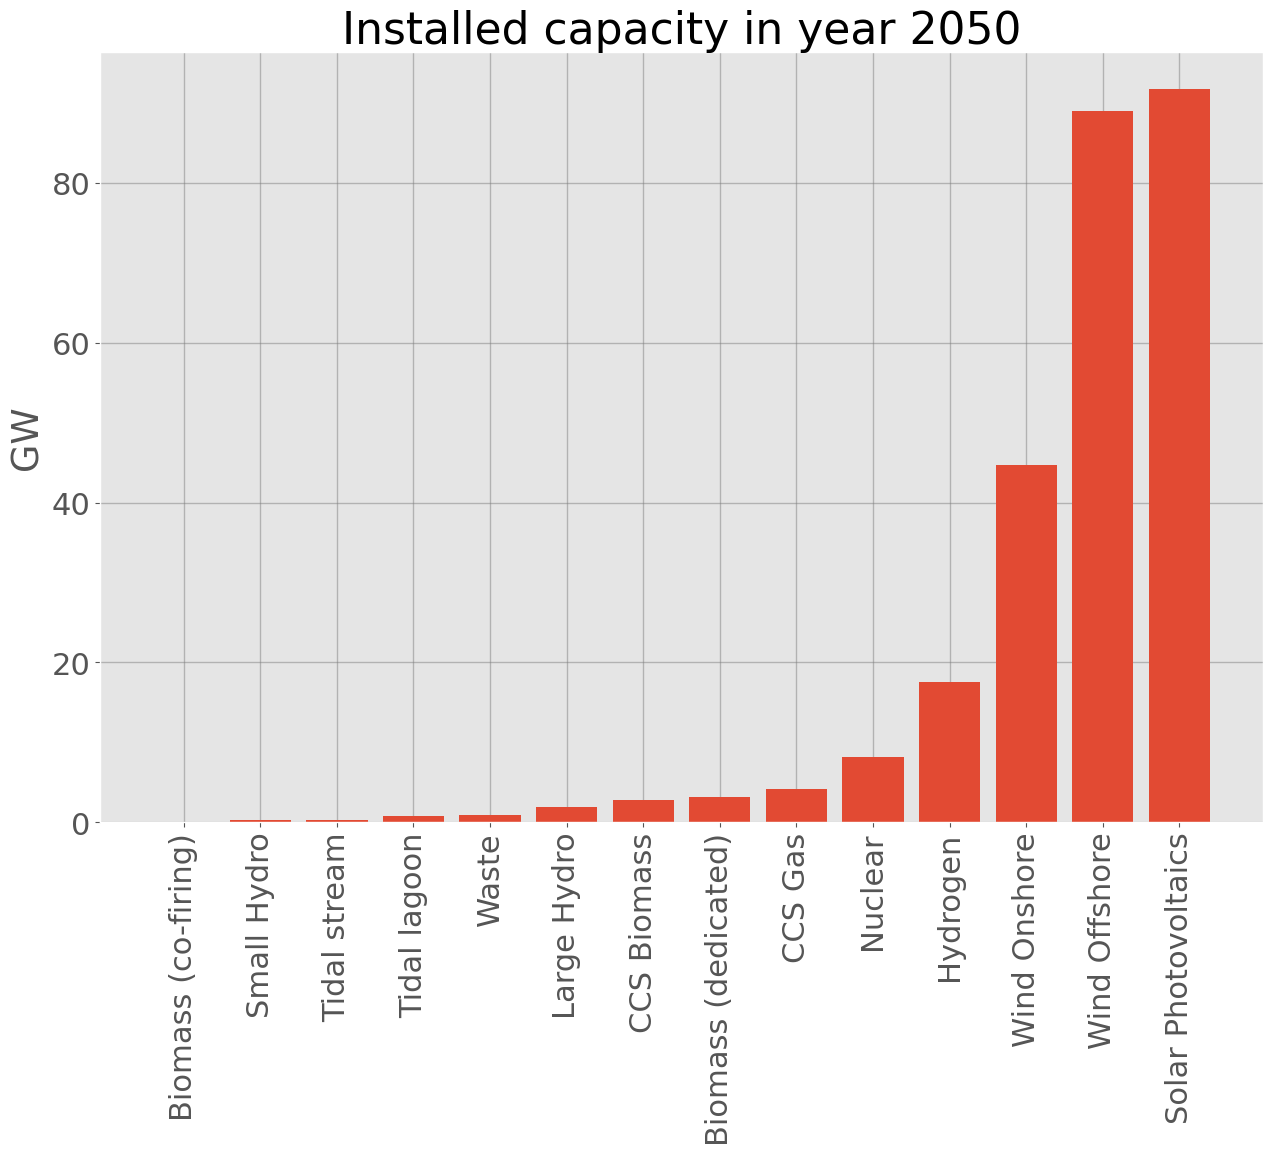

In [7]:
generators_p_nom = df_generators.p_nom.groupby(
    df_generators.carrier).sum().sort_values()
if year > 2020:
    generators_p_nom.drop('Unmet Load', inplace=True)
generators_p_nom.drop(generators_p_nom[generators_p_nom < 50].index, inplace=True)

plt.rcParams.update({'font.size': 22})
# bar chart
plt.figure(figsize=(15,10))
plt.bar(generators_p_nom.index, generators_p_nom.values / 1000)
plt.xticks(generators_p_nom.index, rotation=90)
plt.ylabel('GW')
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)
plt.title('Installed capacity in year ' + str(year))
plt.show()

In [8]:
generators_p_nom

carrier
Biomass (co-firing)       54.399998
Small Hydro              255.660878
Tidal stream             304.000000
Tidal lagoon             749.000000
Waste                    891.066004
Large Hydro             1951.059131
CCS Biomass             2799.999982
Biomass (dedicated)     3136.960000
CCS Gas                 4209.999987
Nuclear                 8120.000000
Hydrogen               17576.340000
Wind Onshore           44774.700000
Wind Offshore          89057.570000
Solar Photovoltaics    91806.650000
Name: p_nom, dtype: float64

## Marginal prices for fossil fuel power plants

C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB-fix\PyPSA-GB\PyPSA-GB\marginal_costs.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fuel_prices = fuel_prices.resample('0.5H').ffill()
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB-fix\PyPSA-GB\PyPSA-GB\marginal_costs.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dti_end = pd.date_range(
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB-fix\PyPSA-GB\PyPSA-GB\marginal_costs.py:74: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dti = pd.date_range(
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB-fix\PyPSA-GB\PyPSA-GB\marginal_costs.py:97: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ets = ets.resample('0.5H').ffill()
C:\Users\alyden\OneDrive

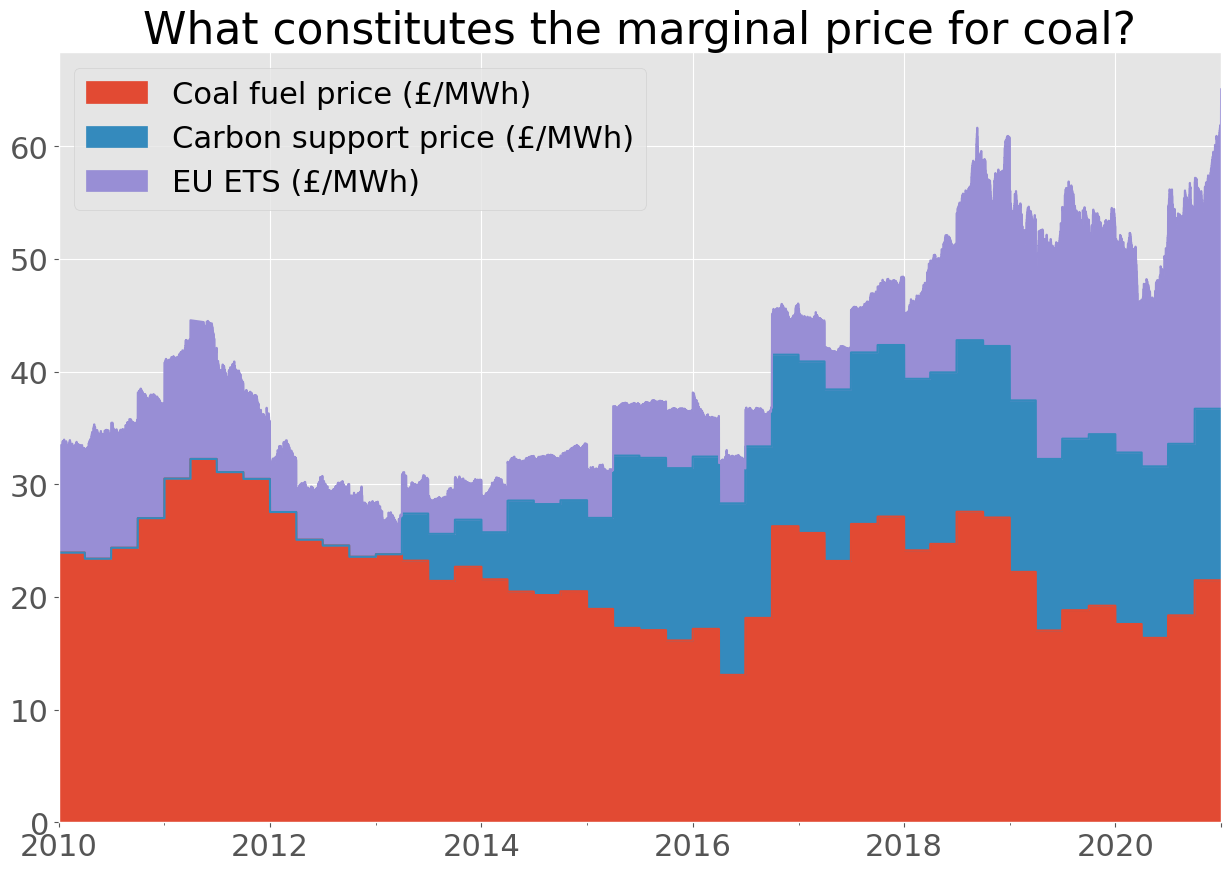

In [9]:
df = pd.read_excel('../data/marginal_cost_data.xlsx', sheet_name=None)

fuel_prices = marginal_costs.fuel_prices_df(df)
carbon_support_price = marginal_costs.carbon_support_price_df(df)
EU_ETS = marginal_costs.EU_ETS_df(df)
EU_ETS.set_index(fuel_prices.index, inplace=True)

result = pd.concat([fuel_prices, carbon_support_price, EU_ETS], axis=1)

# exchange euros for pounds
exch = {2010: 0.8583,
        2011: 0.8678,
        2012: 0.8113,
        2013: 0.8492,
        2014: 0.8061,
        2015: 0.7263,
        2016: 0.8193,
        2017: 0.8766,
        2018: 0.8850,
        2019: 0.8773,
        2020: 0.8897}

for year in range(2010, 2021):
    result.loc[:, 'EU ETS (Euros/tonne)'].loc[str(year): str(year)] *= exch[year]
result.rename(
    columns={'EU ETS (Euros/tonne)': 'EU ETS (Pounds/tonne)'},
    inplace=True)

# these are from
# https://www.parliament.uk/globalassets/documents/post/postpn_383-carbon-footprint-electricity-generation.pdf
coal_emission_factor = 846
# really should be different between OCGT and CCGT
gas_emission_factor = 488
# need better reference for oil
# https://www.jcm.go.jp/cl-jp/methodologies/68/attached_document2
oil_emission_factor = 533

result.loc[:, 'Gas carbon tax (p/kWh)'] = (
    result['Carbon support price (Pounds/tonne)'] +
    result['EU ETS (Pounds/tonne)']) * gas_emission_factor / 10000
result.loc[:, 'Coal carbon tax (p/kWh)'] = (
    result['Carbon support price (Pounds/tonne)'] +
    result['EU ETS (Pounds/tonne)']) * coal_emission_factor / 10000
result.loc[:, 'Oil carbon tax (p/kWh)'] = (
    result['Carbon support price (Pounds/tonne)'] +
    result['EU ETS (Pounds/tonne)']) * oil_emission_factor / 10000

# converting to £/MWh
result.loc[:, 'Gas'] = (
    result['Gas carbon tax (p/kWh)'] +
    result['Gas (p/kWh)']) * 10
result.loc[:, 'Coal'] = (
    result['Coal carbon tax (p/kWh)'] +
    result['Coal (p/kWh)']) * 10
result.loc[:, 'Oil'] = (
    result['Oil carbon tax (p/kWh)'] +
    result['Oil (p/kWh)']) * 10

frame = {'Coal fuel price (£/MWh)': result['Coal (p/kWh)'] * 10,
         'Carbon support price (£/MWh)': result['Carbon support price (Pounds/tonne)'] * coal_emission_factor / 10000 * 10,
         'EU ETS (£/MWh)': result['EU ETS (Pounds/tonne)'] * coal_emission_factor / 10000 * 10}
df_coal = pd.DataFrame(frame)
df_coal.plot.area(figsize=(15,10))
plt.title('What constitutes the marginal price for coal?')
plt.show()

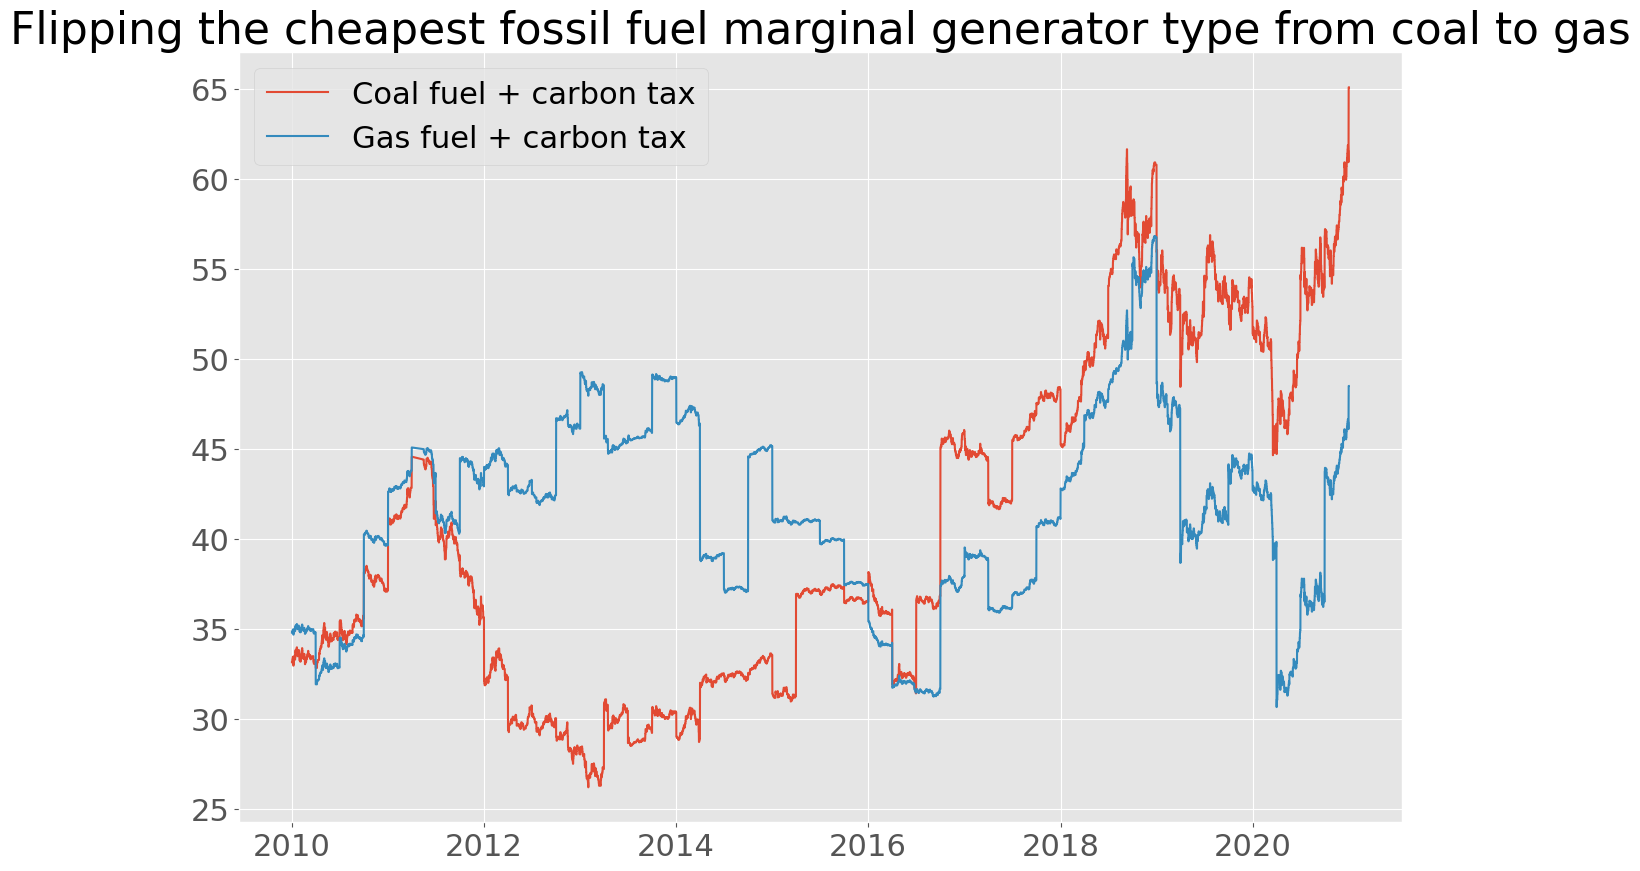

In [10]:
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(result['Coal'], label='Coal fuel + carbon tax')
plt.plot(result['Gas'], label='Gas fuel + carbon tax')
plt.legend(loc='best')
plt.title('Flipping the cheapest fossil fuel marginal generator type from coal to gas')
plt.show()

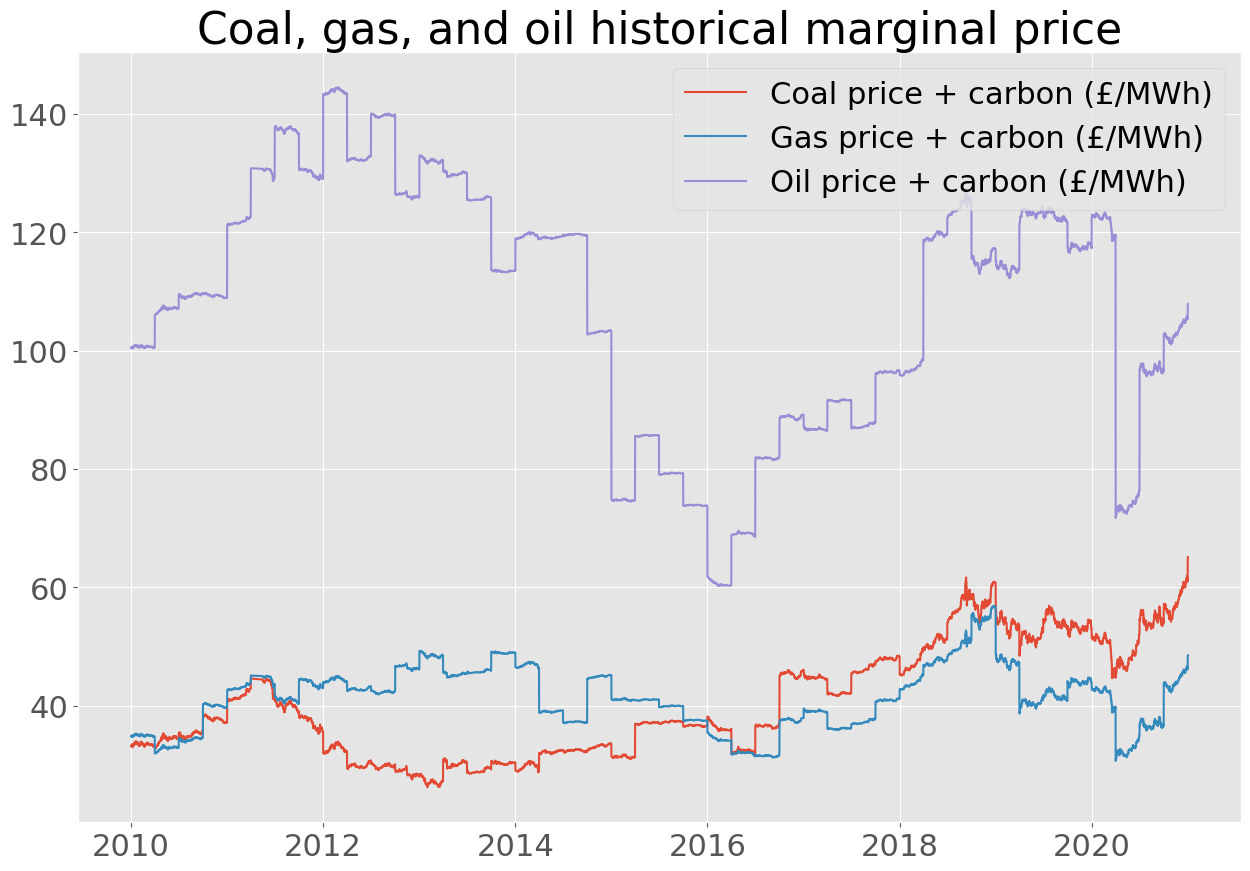

In [11]:
marginal_prices = result[['Coal', 'Gas', 'Oil']].copy()
plt.plot(marginal_prices)
plt.legend(['Coal price + carbon (£/MWh)', 'Gas price + carbon (£/MWh)', 'Oil price + carbon (£/MWh)'], loc='best')
plt.title('Coal, gas, and oil historical marginal price')
plt.show()

In [12]:
# add the future prices
FES = 2022
future_fuel_price = marginal_costs.future_fuel_prices_df(FES)
future_fuel_price = future_fuel_price.apply(pd.to_numeric, errors='coerce')
future_carbon_price = marginal_costs.future_carbon_prices_df(FES)
future_carbon_price = future_carbon_price.apply(pd.to_numeric, errors='coerce')

future_result = pd.concat([future_fuel_price, future_carbon_price], axis=1)

future_result.loc[:, 'Gas carbon tax (p/kWh)'] = (
    future_result['High case']) * gas_emission_factor / 10000
future_result.loc[:, 'Coal carbon tax (p/kWh)'] = (
    future_result['High case']) * coal_emission_factor / 10000
future_result.loc[:, 'Oil carbon tax (p/kWh)'] = (
    future_result['High case']) * oil_emission_factor / 10000

# converting to £/MWh
# gas is in p/therm, divide by 29.3 * 0.5 = 14.65, assume elec efficiency 50%
# this gets us to p/kWh, then * 10 to get £/MWh
future_result.loc[:, 'Gas'] = (
    future_result['Gas carbon tax (p/kWh)'] * 10 +
    future_result['Gas price'] * 10 / 14.65)
# coal is in USD per tonne, * 0.75 to get pounds
# one tonne can create 2.460 MWh electricity, divide by this
# to get £/MWh
# also a 1.4 fudge factor to get closer to 2020 price
future_result.loc[:, 'Coal'] = (
    future_result['Coal carbon tax (p/kWh)'] * 10 +
    future_result['Coal price'] * 1.4 * 0.8 / 2.460)
# oil is in $ per barrel, so * 0.75 to get pounds
# 1.7 MWh per barrel thermal, so *0.3 to get 0.85 MWh elec
# divide by this to get £/MWh
future_result.loc[:, 'Oil'] = (
    future_result['Oil carbon tax (p/kWh)'] * 10 +
    future_result['Oil price'] * 0.8 / 0.51)

marginal_prices2 = future_result[['Coal', 'Gas', 'Oil']].copy()

marginal_prices = pd.concat([marginal_prices, marginal_prices2])
marginal_prices

C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB-fix\PyPSA-GB\PyPSA-GB\marginal_costs.py:58: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_FES = df_FES.resample('0.5H').ffill()
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB-fix\PyPSA-GB\PyPSA-GB\marginal_costs.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dti = pd.date_range(
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB-fix\PyPSA-GB\PyPSA-GB\marginal_costs.py:130: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_FES = df_FES.resample('0.5H').ffill()
C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB-fix\PyPSA-GB\PyPSA-GB\marginal_costs.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dti = pd.date_range(


,Coal,Gas,Oil
2010-01-01 00:00:00,33.14282,34.786835,100.481909
2010-01-01 00:30:00,33.14282,34.786835,100.481909
2010-01-01 01:00:00,33.14282,34.786835,100.481909
2010-01-01 01:30:00,33.14282,34.786835,100.481909
2010-01-01 02:00:00,33.14282,34.786835,100.481909
...,...,...,...
2050-12-31 21:30:00,162.66601,111.018724,144.796921
2050-12-31 22:00:00,162.66601,111.018724,144.796921
2050-12-31 22:30:00,162.66601,111.018724,144.796921
2050-12-31 23:00:00,162.66601,111.018724,144.796921


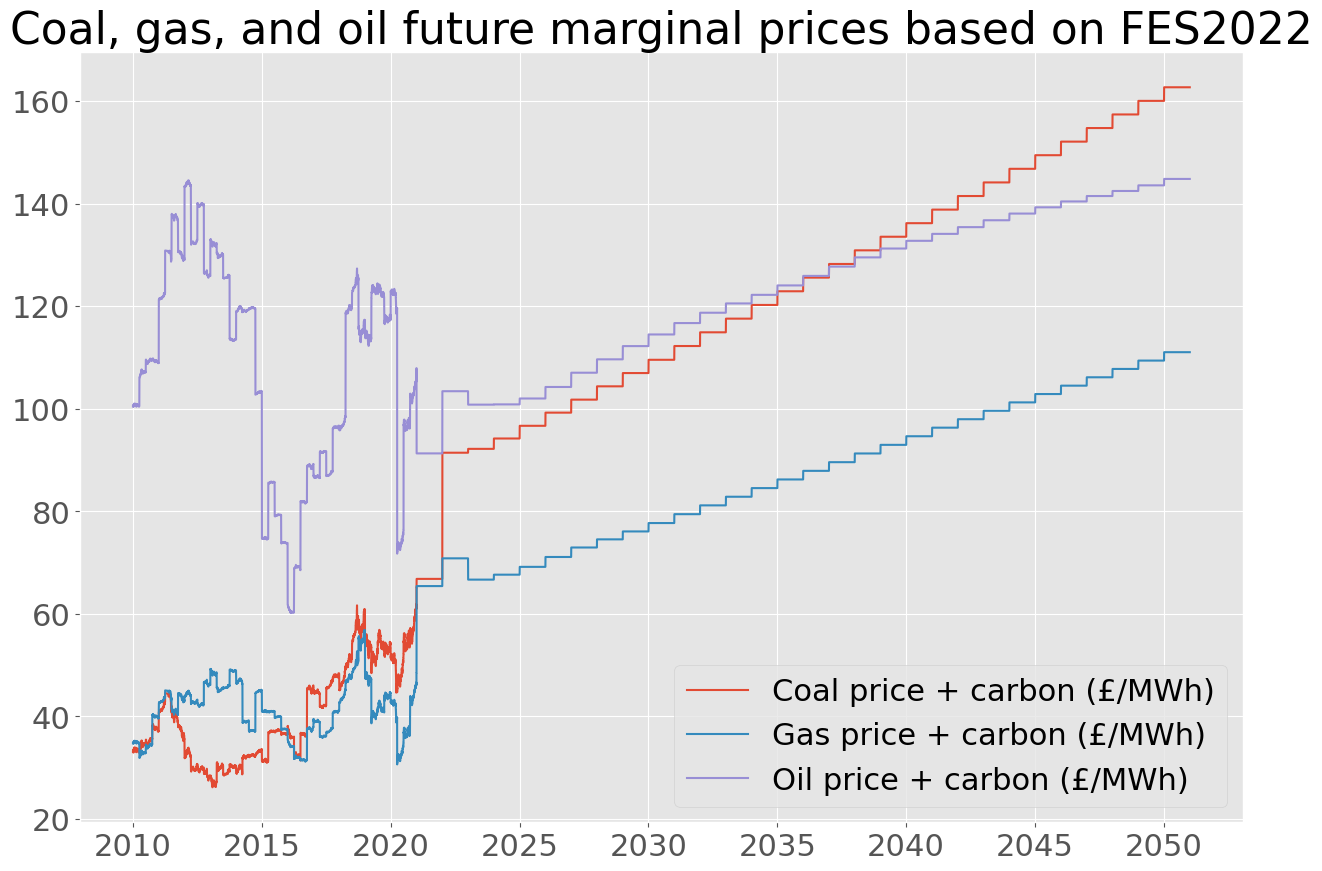

In [13]:
plt.plot(marginal_prices)
plt.legend(['Coal price + carbon (£/MWh)', 'Gas price + carbon (£/MWh)', 'Oil price + carbon (£/MWh)'], loc='best')
plt.title('Coal, gas, and oil future marginal prices based on FES2022')
plt.show()